# Introduction
Xây dựng model YOLO cho bài toán Object Detection: ta sẽ xây dựng từ bài toán Classification, sau đó thêm vào task Localization và cuối cùng là Object Detection (YOLO)

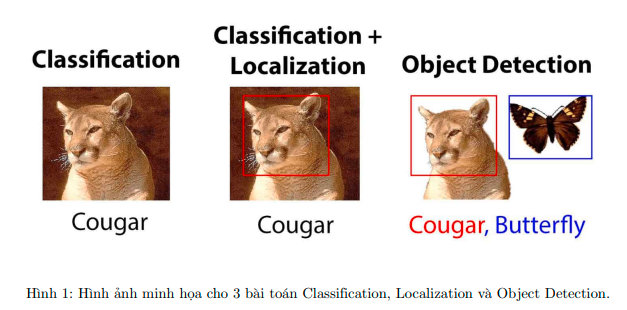

* **Classification** chỉ đơn giản là phân loại một object trong ảnh
* **Localization** không chỉ phân loại mà còn xác định vị trí của object đó bằng bounding box
* **Object Detection** kết hợp cả hai yếu tố này để phát hiện và định vị nhiều object trong một hình ảnh

# Classification (nhiều hơn 1 object trong ảnh) + Localization (bounding box)
Trong bài toán thứ ba, chúng ta mở rộng phạm vi của **classification** bằng cách xử lý hình ảnh **chứa nhiều hơn hai object** và thực hiện **bounding box regression** để định vị các object này. Bài toán này đòi hỏi mô hình không chỉ phân loại các object mà còn xác định chính xác vị trí của từng object
trong hình ảnh.

## Import và tải thư viện
Để bắt đầu, chúng ta cần import các thư viện cần thiết và tải xuống bộ dữ liệu. Bộ dữ liệu này bao gồm các hình ảnh của mèo và chó, được sử dụng rộng rãi trong các bài toán Image Classification và Object Detection. Việc sử dụng bộ dữ liệu từ kagglehub giúp chúng ta dễ dàng quản lý và truy cập dữ liệu một cách hiệu quả.

In [1]:
import kagglehub

# Download the latest dataset version
data_dir = kagglehub.dataset_download("andrewmvd/dog-and-cat-detection")
print("Path to dataset files:", data_dir)


100%|██████████| 1.03G/1.03G [00:05<00:00, 209MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/andrewmvd/dog-and-cat-detection/versions/1


In [5]:
import os
import torch
import random
import numpy as np
import pandas as pd
import seaborn as sns
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import torch.nn.functional as F
import matplotlib.patches as patches
import xml.etree.ElementTree as ET
import tqdm.notebook as tqdm

from PIL import Image
from torchvision import transforms, models
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from torchvision.models.resnet import ResNet18_Weights, ResNet50_Weights

## Định Nghĩa Class Dataset với Nhiều object
Chúng ta sẽ định nghĩa một lớp MyDataset để xử lý các hình ảnh chứa nhiều object và thực hiện các thao tác như merge hình ảnh, chia thành các patch, và chuẩn bị dữ liệu cho mô hình.

Trong class MyDataset, chúng ta thực hiện các bước sau:
* **Merge hình ảnh**: Chọn ngẫu nhiên hai hình ảnh và ghép chúng lại thành một hình ảnh duy nhất bằng cách dán hai hình ảnh cạnh nhau.
* **Chia thành các patch**: Sau khi ghép, hình ảnh được chia thành 4 phần (patch) để mô hình dễ dàng xử lý và định vị các object trong từng phần.
* **Điều chỉnh annotations**: Điều chỉnh tọa độ bounding box của object trong patch mới sau khi ghép hình ảnh.
* **Trả về dữ liệu**: Mỗi mẫu dữ liệu bao gồm 4 patch hình ảnh và các annotations tương ứng cho từng patch.

In [12]:
# Dataset Class
class MyDataset(Dataset):
  def __init__(self, annotations_dir, image_dir, transform = None):
    self.annotations_dir = annotations_dir
    self.image_dir = image_dir
    self.transform = transform
    self.image_files = self.filter_images_with_multiple_objects()

  def filter_images_with_multiple_objects(self):
    valid_image_files = []
    for f in os.listdir(self.image_dir):
      if os.path.isfile(os.path.join(self.image_dir, f)):
        img_name = f
        annotation_name = os.path.splitext(img_name)[0] + ".xml"
        annotation_path = os.path.join(self.annotations_dir, annotation_name)

        if self.count_objects_in_annotation(annotation_path) == 1:
          valid_image_files.append(img_name)
        #else:
        #  print(f" Image { img_name } has multiple objects and will be excluded from the dataset")
    return valid_image_files

  def count_objects_in_annotation(self, annotation_path):
    try:
      tree = ET.parse(annotation_path)
      root = tree.getroot()
      count = 0
      for obj in root.findall("object"):
        count += 1
      return count
    except FileNotFoundError:
      return 0

  def parse_annotation(self, annotation_path):
    tree = ET.parse(annotation_path)
    root = tree.getroot()

    # Get image size for normalization
    image_width = int(root.find('size/width').text)
    image_height = int(root.find('size/height').text)

    label = None
    bbox = None
    for obj in root.findall("object"):
      name = obj.find("name").text
      if (label is None) : # Take the first label for now . We are working with 1 label per image
        label = name
        # Get bounding box coordinates
        xmin = int(obj.find('bndbox/xmin').text)
        ymin = int(obj.find('bndbox/ymin').text)
        xmax = int(obj.find('bndbox/xmax').text)
        ymax = int(obj.find('bndbox/ymax').text)

        # Normilize bbox coordinates to [0, 1]
        bbox = [xmin / image_width,
                ymin / image_height,
                xmax / image_width,
                ymax / image_height
                ]

    # Convert label to numerical representation (0 for cat , 1 for dog)
    label_num = 0 if label == "cat" else 1 if label == "dog" else -1

    return label_num, torch.tensor(bbox, dtype=torch.float32)

  def __len__(self):
    return len(self.image_files)

  def __getitem__(self, idx):
    # Image path
    img1_file = self.image_files[idx]
    img1_path = os.path.join(self.image_dir, img1_file)

    # Annotation path
    annotation_name = os.path.splitext(img1_file)[0] + ".xml"
    img1_annotations = self.parse_annotation(os.path.join(self.annotations_dir, annotation_name))

    idx2 = random.randint(0, len(self.image_files) - 1)
    img2_file = self.image_files[idx2]
    img2_path = os.path.join(self.image_dir, img2_file)

    annotation_name = os.path.splitext(img2_file)[0] + ".xml"
    img2_annotations = self.parse_annotation(os.path.join(self.annotations_dir, annotation_name))

    img1 = Image.open(img1_path).convert("RGB")
    img2 = Image.open(img2_path).convert("RGB")

    # Horizontal merge
    merged_image = Image.new(
        "RGB", (img1.width + img2.width, max(img1.height, img2.height))
    )
    merged_image.paste(img1, (0, 0))
    merged_image.paste(img2, (img1.width, 0))

    # Vertical merge
    merged_w = img1.width + img2.width
    merged_h = max(img1.height, img2.height)

    merged_annotations = []

    # No change for objects from img1
    merged_annotations.append({'bbox':img1_annotations[1], 'label':img1_annotations[0]})

    # Adjust bbox coordinates for objects from img2
    new_bbox = [
        img2_annotations[1][0] + img1.width,
        img2_annotations[1][1],
        img2_annotations[1][2] + img1.width,
        img2_annotations[1][3]
    ]
    merged_annotations.append({'bbox':new_bbox, 'label':img2_annotations[0]})

    # Split the merged image into 4 patches
    patch_width = merged_w // 2
    patch_height = merged_h // 2
    patches = []
    patch_annotations = [] # list of dictionary

    for i in range(2):
      for j in range(2):
        left = j * patch_width
        upper = i * patch_height
        right = (j + 1) * patch_width
        lower = (i + 1) * patch_height

        patch = merged_image.crop((left, upper, right, lower))
        patches.append(patch)

        current_patch_annotations = []
        for anno in merged_annotations:
          center_x, center_y = self.calculate_center(anno['bbox'])

          # Check if the center of the ground truth bbox is within the patch
          if left <= center_x < right and upper <= center_y < lower:
            current_patch_annotations.append({'bbox': anno['bbox'], 'label': anno['label']})
            break

        if len(current_patch_annotations) == 0:
          current_patch_annotations.append({'bbox':[0, 0, 0, 0], 'label': 0}) # dummy bbox for the other object

        patch_annotations.append(current_patch_annotations[0])

    # Transform and convert to tensors
    if self.transform:
      patches = [self.transform(patch) for patch in patches]

    patches = torch.stack(patches) # shape (4, C, H, W)
    patch_annotations = [{"bbox": torch.tensor(patch['bbox'], dtype=torch.float32),
                          "label": torch.tensor(patch["label"], dtype=torch.long)} for patch in patch_annotations]

    return patches, patch_annotations

  def calculate_center(self, bbox):
    return ((bbox[0] + bbox[2]) / 2, (bbox[1] + bbox[3]) / 2)


## Phân Tích và Chuẩn Bị Dữ Liệu
Sau khi định nghĩa class dataset, chúng ta tiến hành phân tích và chuẩn bị dữ liệu.

In [13]:
# Data directory
annotations_dir = os.path.join(data_dir, 'annotations')
image_dir = os.path.join(data_dir, 'images')

# Define transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

# Create dataset and dataloaders
dataset = MyDataset(annotations_dir, image_dir, transform=transform)
train_dataset, val_dataset = train_test_split(dataset, test_size=0.2, random_state=42)

# Create dataloaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=8, shuffle=False)

# Get list of image files and create a dummy dataframe to split the data
#image_files = [f for f in os.listdir(image_dir) if os.path.isfile(os.path.join(image_dir, f))]
#df = pd.DataFrame({'image_name': image_files})

# Split data
#train_df, val_df = train_test_split(df, test_size=0.2, random_state=42)

<ipython-input-12-2d309d99f39f>:148: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  patch_annotations = [{"bbox": torch.tensor(patch['bbox'], dtype=torch.float32),


## Xây Dựng Model với Hai Head
Chúng ta sẽ xây dựng một mô hình có hai head: một để classification và một để dự đoán bounding box. Trong trường hợp này, chúng ta sử dụng ResNet50 làm backbone cho mô hình.

In [15]:
# Model with Two Heads
class SimpleYOLO(nn.Module):
  def __init__(self, num_classes=2):
    super(SimpleYOLO, self).__init__()

    #  Base model: use pre-trained ResNet50
    self.backbone = models.resnet50(weights = ResNet50_Weights.DEFAULT)
    self.num_classes = num_classes

    # Remove the final classification layer of ResNet
    self.backbone = nn.Sequential(*list(self.backbone.children())[:-2])

    self.avgpool = nn.AdaptiveAvgPool2d((1,1)) # For classification

    # Separate heads for each patch
    # Classification head
    self.classifiers = nn.ModuleList([nn.Linear(2048, num_classes) for _ in range(4)])
    # Bounding box regression head
    self.regressors = nn.ModuleList([nn.Linear(2048, 4) for _ in range(4)]) # for 4 values for bbox

  def forward(self, x):
    # x shape: (batch_size, 4, C, H, W) 4 patches
    batch_size = x.shape[0]
    features = []

    for i in range(4):
      patch_features = self.backbone(x[:, i, :, :, :]) # (batch_size, C, H, W)
      features.append(patch_features)

    class_outputs = []
    reg_outputs = []

    for i in range(4):
      # Classification head
      class_feat = self.avgpool(features[i]).view(batch_size, -1) # Global average pooling
      class_output = self.classifiers[i](class_feat)
      class_outputs.append(class_output)

      # Regression head
      reg_output = self.regressors[i](features[i].mean(dim=[2,3]))
      reg_outputs.append(reg_output)

    return class_outputs, reg_outputs # return list of tensor with length = 4

# Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
num_classes = 2 # Assuming two classes: dog and cat
class_to_idx = {'dog': 0, 'cat': 1}

# Model
model = SimpleYOLO(num_classes=num_classes).to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Show model summary
#print(model)

Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 198MB/s]


## Training loop
Cuối cùng, chúng ta sẽ training model trên **train set** và evaluate trên **test set**

In [16]:
def calculate_loss(class_outputs, reg_outputs, targets, device, num_classes):
  class_to_idx = {'dog': 0 , 'cat': 1}
  total_loss = 0

  for i in range(4) : # Loop through each patch
    class_targets_tensor = F.one_hot(targets[i]['label'], num_classes=num_classes ).to(device).float()
    bbox_targets_tensor = targets[i]['bbox'].to(device)

    # Classification Loss
    if len( class_targets_tensor ) > 0:
      classification_loss = nn.MSELoss()(class_outputs[i], class_targets_tensor)
    else:
      classification_loss = torch.tensor(0.0, device=device)

    # Regression Loss
    if len(bbox_targets_tensor) > 0:
      regression_loss = nn.MSELoss()(reg_outputs[i], bbox_targets_tensor)
    else:
      regression_loss = torch.tensor(0.0, device = device)

    total_loss += classification_loss + regression_loss

  return total_loss

In [17]:
def evaluate_model(model, data_loader, device, num_classes, class_to_idx):
  model.eval()
  running_loss = 0.0
  correct_val = 0
  total_val = 0
  with torch.no_grad():
    for patches, patch_annotations in data_loader:
      patches = patches.to(device)

      class_outputs, reg_outputs = model(patches)

      total_loss = calculate_loss(class_outputs, reg_outputs, patch_annotations, device, num_classes)

      # Calculate accuracy
      for i in range(4):
        class_predictions = class_outputs[i].argmax(dim=1)
        class_targets = patch_annotations[i]['label']
        correct_val += (class_predictions == class_targets.to(device)).sum().item()

        total_val += len(class_targets)
      running_loss += total_loss.item()

  val_loss = running_loss / len(data_loader)
  val_accuracy = correct_val / total_val if total_val > 0 else 0
  return val_loss, val_accuracy

In [18]:
def train_model(model, train_loader, val_loader, optimizer, num_epochs, device, num_classes, class_to_idx):
  best_val_accuracy = 0.0
  train_losses = []
  val_losses = []
  train_accuracies = []
  val_accuracies = []

  for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0

    for patches, patch_annotations in tqdm.tqdm(train_loader):
      patches = patches.to(device)

      optimizer.zero_grad()
      class_outputs, reg_outputs = model(patches)

      total_loss = calculate_loss(class_outputs, reg_outputs, patch_annotations, device, num_classes)

      total_loss.backward()
      optimizer.step()
      running_loss += total_loss.item()

    epoch_loss = running_loss / len(train_loader)
    train_losses.append(epoch_loss)

    # Validation
    val_loss, val_accuracy = evaluate_model(model, val_loader, device, num_classes, class_to_idx)
    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)

    print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {epoch_loss:.4f}, Validation Loss: {val_loss:.4f}, Validation Accuracy : {val_accuracy:.4f}')

    # Save the best model
    if val_accuracy > best_val_accuracy:
      best_val_accuracy = val_accuracy
      torch.save(model.state_dict(), 'best_model.pth')

  return train_losses , val_losses , train_accuracies , val_accuracies

# Train the model
num_epochs = 10
train_losses, val_losses, train_accuracies, val_accuracies = train_model(
    model, train_loader, val_loader, optimizer, num_epochs, device, num_classes, class_to_idx)


  0%|          | 0/93 [00:00<?, ?it/s]

Epoch 1/10, Train Loss: 43791.4954, Validation Loss: 33661.4606, Validation Accuracy : 0.8083


  0%|          | 0/93 [00:00<?, ?it/s]

Epoch 2/10, Train Loss: 27148.6511, Validation Loss: 25294.9180, Validation Accuracy : 0.8083


  0%|          | 0/93 [00:00<?, ?it/s]

Epoch 3/10, Train Loss: 25429.0557, Validation Loss: 25031.2713, Validation Accuracy : 0.7955


  0%|          | 0/93 [00:00<?, ?it/s]

Epoch 4/10, Train Loss: 23121.6138, Validation Loss: 24409.5144, Validation Accuracy : 0.8114


  0%|          | 0/93 [00:00<?, ?it/s]

Epoch 5/10, Train Loss: 21234.2616, Validation Loss: 22450.7628, Validation Accuracy : 0.7822


  0%|          | 0/93 [00:00<?, ?it/s]

Epoch 6/10, Train Loss: 20965.7215, Validation Loss: 24215.4349, Validation Accuracy : 0.7710


  0%|          | 0/93 [00:00<?, ?it/s]

Epoch 7/10, Train Loss: 21519.3754, Validation Loss: 20943.6656, Validation Accuracy : 0.7761


  0%|          | 0/93 [00:00<?, ?it/s]

Epoch 8/10, Train Loss: 19492.2801, Validation Loss: 20576.6758, Validation Accuracy : 0.8185


  0%|          | 0/93 [00:00<?, ?it/s]

Epoch 9/10, Train Loss: 19135.2364, Validation Loss: 19681.8858, Validation Accuracy : 0.7972


  0%|          | 0/93 [00:00<?, ?it/s]

Epoch 10/10, Train Loss: 17260.0187, Validation Loss: 20343.5212, Validation Accuracy : 0.8409


**Inference**

Sau khi huấn luyện, chúng ta có thể sử dụng mô hình để thực hiện dự đoán trên các hình ảnh mới

<ipython-input-19-400226b6b9bc>:55: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('best_model.pth'))


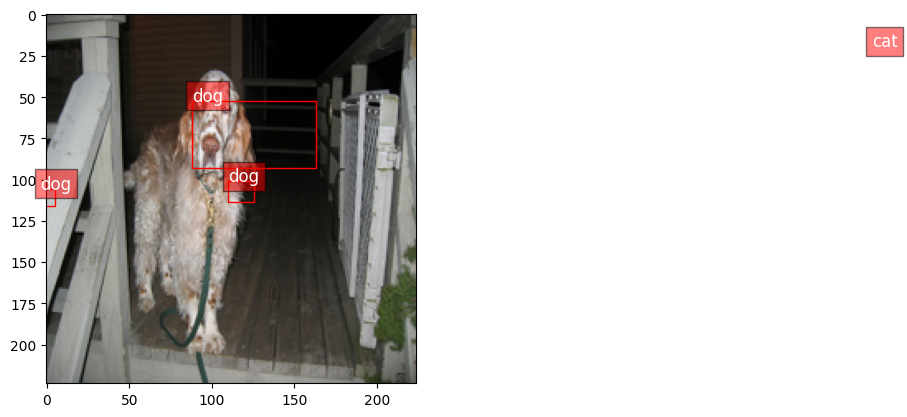

In [19]:
def inference(model, image_path, transform, device, class_to_idx, threshold=0.5):
  model.eval()
  image = Image.open(image_path).convert("RGB")
  original_width, original_height = image.size

  # Resize the image to match the input size expected by the model
  resized_image = image.resize((224, 224))

  # Apply the same transformations used during training
  transformed_image = transform(resized_image).unsqueeze(0).to(device)

  # Split the image into 4 patches
  patch_width = transformed_image.shape[3] // 2
  patch_height = transformed_image.shape[2] // 2
  image_patches = []

  for i in range(2):
    for j in range(2):
      left = j * patch_width
      upper = i * patch_height
      right = (j + 1) * patch_width
      lower = (i + 1) * patch_height
      patch = transformed_image[0, :, upper:lower, left:right].unsqueeze(0)
      image_patches.append(patch)

  image_patches = torch.cat(image_patches, dim=0).unsqueeze(0) # Add an extra dimension at the beginning

  with torch.no_grad():
    class_outputs, reg_outputs = model(image_patches)

  fig, ax = plt.subplots(1)
  ax.imshow(resized_image)

  for i in range(4):
    # Get the class prediction and bounding box for the current patch
    class_pred = class_outputs[i].argmax(dim=1).item()
    bbox = reg_outputs[i].squeeze().tolist()

    # Scale the bounding box back to the original image size
    x_min = min(bbox[0] * patch_width + (i % 2) * patch_width, original_width)
    y_min = min(bbox[1] * patch_height + (i // 2) * patch_height, original_height)
    x_max = max(bbox[2] * patch_width + (i % 2) * patch_width, 0)
    y_max = max(bbox[3] * patch_height + (i // 2) * patch_height, 0)

    # Draw the bounding box and label on the image
    if class_outputs[i].max().item() > threshold:
      rect = patches.Rectangle((x_min, y_min), x_max - x_min, y_max - y_min,
                               linewidth=1, edgecolor='r', facecolor='none')
      ax.add_patch(rect)
      plt.text(x_min, y_min, f'{list(class_to_idx.keys())[class_pred]}',
               color='white', fontsize=12, bbox= dict(facecolor='red', alpha=0.5))
  plt.show()

# Load the best model
model.load_state_dict(torch.load('best_model.pth'))

# Inference
image_path = os.path.join(image_dir, 'Cats_Test431.png')
inference(model, image_path, transform, device, class_to_idx)